# Climate event detection task
Sandbox for preprocessing and first learning test

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys
sys.path.append('../..')

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

# on CLI,  export LD_LIBRARY_PATH=/usr/local/cuda-9.0/extras/CUPTI/lib64:$LD_LIBRARY_PATH

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs

In [3]:
os.environ["AWS_ACCESS_KEY_ID"] = '8XXMJZDHP2B1DCH75BUQ'                 # Credentials only needed if connecting to a private endpoint
os.environ["AWS_SECRET_ACCESS_KEY"] = 'OeqXFSQ+7Nudj9pe=JNja1RlRq5qIFb2aV9Fpvcw'
os.environ["S3_ENDPOINT"] = 's3.epfl.ch'  # The S3 API Endpoint to connect to. This is specified in a HOST:PORT format.
os.environ["S3_USE_HTTPS"] = '1'
# or 'export' them before on CLI. Seems to work better

In [4]:
import h5py

In [5]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

List of parameters:
* TMQ: Total (vertically integrated) precipitatable water
* U850: Zonal wind at 850 mbar pressure surface
* V850: Meridional wind at 850 mbar pressure surface
* UBOT: Lowest model level zonal wind
* VBOT: Lowest model level meridional wind
* QREFHT: Reference height humidity
* PS: Surface pressure
* PSL: sea level pressure
* T200: temp at 200 mbar pressure surface
* T500: temp at 500 mbar pressure surface
* PRECT: Total (convective and large-scale) precipitation rate (liq + ice)
* TS: Surface temperature (radiative)
* Z100: Geopotential Z at 100 mbar pressure surface
* Z200: Geopotential Z at 200 mbar pressure surface
* ZBOT: Lowest model level height

resolution of 768 x 1152 equirectangular grid (25-km at equator)

The labels are 0 for background class, 1 for tropical cyclone, and 2 for atmoshperic river

In [6]:
path = '../../data/Climate/'

In [ ]:
year, month, day, hour, run = 2106, 1, 1, 0, 1
datapath = '../../data/Climate/data_5_all/data-{}-{:0>2d}-{:0>2d}-{:0>2d}-{}-mesh.npz'.format(year, month, day, hour, run)

In [ ]:
plop = np.load(datapath)
data = plop["data"]
labels = plop["labels"]

In [ ]:
data.shape

In [ ]:
stats = h5py.File('../../data/Climate/stats.h5')
stats = stats['climate']["stats"] # (16 X 4) (mean, max, min, std)

In [ ]:
year, month, day, hour, run = 2106, 1, 1, 0, 1
datapath = '../../data/Climate/data-{}-{:0>2d}-{:0>2d}-{:0>2d}-{}.h5'.format(year, month, day, hour, run)

In [ ]:
h5f = h5py.File(datapath)
data = h5f['climate']["data"] # (16,768,1152) numpy array
labels = h5f['climate']["labels"] # (768,1152) numpy array

In [7]:
lon_ = np.arange(1152)/1152*360
lat_ = np.arange(768)/768*180-90
lon, lat = np.meshgrid(lon_, lat_)

In [8]:
from deepsphere.utils import icosahedron_graph

In [9]:
g = icosahedron_graph(5)

In [10]:
icolong, icolat = np.rad2deg(g.long), np.rad2deg(g.lat)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=data[0,:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(lon, lat, s=1,
            c=labels[:,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=data[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=labels[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [ ]:
from scipy.interpolate import griddata, RectBivariateSpline, RegularGridInterpolator, LinearNDInterpolator, interp2d, NearestNDInterpolator

In [ ]:
from scipy.interpolate import griddata#, RectBivariateSpline, RegularGridInterpolator
Nside = 32
pix = np.arange(12*Nside**2)
coords_hp = hp.pix2ang(Nside, pix, nest=True, lonlat=True)
coords_hp = np.asarray(coords_hp).T
# lon_rad, lat_rad = np.deg2rad(lon), np.deg2rad(lat)
coords_map = hp.ang2vec(lon, lat, lonlat=True).reshape((-1, 3))
coords_map = np.stack([lon, lat], axis=-1).reshape((-1, 2))
# map_hp = griddata(coords_map, images[0,0].flatten(), coords_hp, 'linear')

In [ ]:
t = time.time()
map_hp1 = griddata(coords_map, data[0].flatten(), coords_hp, 'linear')
print("time taken:", time.time()-t)

t = time.time()
f = RegularGridInterpolator((lon_, lat_), data[0].T)
map_hp3 = f(coords_hp)
print("time taken:", time.time()-t)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=map_hp3, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

In [ ]:
coords_map.shape

In [ ]:
f = NearestNDInterpolator(coords_map, labels[:].flatten(), rescale=False)
new_labels = f(coords_hp)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(coords_hp[:,0], coords_hp[:,1], s=10,
            c=new_labels, cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

## data

In [ ]:
from glob import glob
year = 2106
path = '../../data/Climate/data-{}-01*.h5'.format(year)
files = glob(path)
datas = np.zeros((len(files),16,768,1152))
labels = np.zeros((len(files),768,1152))
for i, file in enumerate(files):
#     _, _, month, day, hour, run = file.split('-')
#     month, day, hour, run = int(month), int(day), int(hour), int(run[0])
    data = h5py.File(file)
    datas[i] = data['climate']['data']
    labels[i] = data['climate']['labels']

In [ ]:
from glob import glob
year = 2106
path = '../../data/Climate/data_5_all/data-{}-*.npz'.format(year)
files = glob(path)
datas = np.zeros((len(files),16,10242))
labels = np.zeros((len(files),3,10242))
for i, file in enumerate(files):
#     _, _, month, day, hour, run = file.split('-')
#     month, day, hour, run = int(month), int(day), int(hour), int(run[0])
    data = np.load(file)
    datas[i] = data['data']
    labels[i] = data['labels']
#     datas.append(data)
#     labels.append(label)
# datas = np.stack(datas)
# labels = np.stack(labels)
labels = np.argmax(labels, axis=1)
datas = np.transpose(datas, axes=(0,2,1))

In [ ]:
limit=6000
x_train = datas[:limit,:,:]
labels_train = labels[:limit,:]
x_val = datas[limit:,:,:]
labels_val = labels[limit:,:]

training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

Jiang separation

In [69]:
precomp_mean = [26.160023, 0.98314494, 0.116573125, -0.45998842, 0.1930554, 0.010749293, 98356.03, 100982.02, 216.13145, 258.9456, 3.765611e-08, 288.82578, 288.03925, 342.4827, 12031.449, 63.435772]
precomp_std =  [17.04294, 8.164175, 5.6868863, 6.4967732, 5.4465833, 0.006383436, 7778.5957, 3846.1863, 9.791707, 14.35133, 1.8771327e-07, 19.866386, 19.094095, 624.22406, 679.5602, 4.2283397]


In [70]:
rotmat = np.array([[np.cos(np.pi/4),np.sin(np.pi/4)],
                    [-np.sin(np.pi/4),np.cos(np.pi/4)]])
# change to magnitude

In [86]:
data = {}
for partition in ['val']:
    with open(path+'data_5_all/'+partition+".txt", "r") as f:
        lines = f.readlines()
    flist = [os.path.join(path, 'data_5_all', l.replace('\n', '')) for l in lines]
    data[partition] = {'data': np.zeros((len(flist),10242,16)),
                       'labels': np.zeros((len(flist),10242))}
    for i, f in enumerate(flist):
        file = np.load(f)
        data[partition]['data'][i] = (file['data'].T - precomp_mean) / precomp_std
        data[partition]['data'][i,:,1] = np.arctan2(data[partition]['data'][i,:,1], data[partition]['data'][i,:,2])# data[partition]['data'][i,:,1:3] @ rotmat
        data[partition]['data'][i,:,2] = data[partition]['data'][i,:,1]
        data[partition]['data'][i,:,3] = np.arctan2(data[partition]['data'][i,:,3], data[partition]['data'][i,:,4]) # @ rotmat
        data[partition]['data'][i,:,4] = data[partition]['data'][i,:,3]
        data[partition]['labels'][i] = np.argmax(file['labels'].astype(np.int), axis=0)

In [12]:
x_train = data['train']['data']
labels_train = data['train']['labels']

KeyError: 'train'

In [72]:
x_test = data['test']['data']
labels_test = data['test']['labels']

In [87]:
# training = LabeledDataset(data['train']['data'], data['train']['labels'])
validation = LabeledDataset(data['val']['data'], data['val']['labels'])
# test = LabeledDataset(data['test']['data'], data['test']['labels'])

In [88]:
del data

TF dataset with Jiang separation

In [7]:
from ClimateDataLoader import IcosahedronDataset, EquiangularDataset

In [8]:
training = IcosahedronDataset(path+'data_5_all/', 'train')

In [9]:
validation = IcosahedronDataset(path+'data_5_all/', 'val')

In [76]:
tf_train = training.get_tf_dataset(32)

In [19]:
import tensorflow as tf
from tqdm import tqdm

data_next = tf_train.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = training.N // 32 + 1
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    try:
        for i in tqdm(range(steps)):
            out = sess.run(data_next)
    except tf.errors.OutOfRangeError:
        print("Done") 

100%|██████████| 1373/1373 [03:15<00:00,  7.01it/s]


In [10]:
training_local = EquiangularDataset(path, s3=False)

In [11]:
validation_local = EquiangularDataset(path, 'val', s3=False)

In [15]:
tf_local = training_local.get_tf_dataset(1)

In [16]:
from pygsp.graphs import SphereEquiangular

In [17]:
g2 = SphereEquiangular(bandwidth=(384, 576), sampling='SOFT')

In [19]:
glong, glat = np.rad2deg(g2.lon), np.rad2deg(g2.lat)

  0%|          | 0/80 [00:00<?, ?it/s]


5.2670018672943115


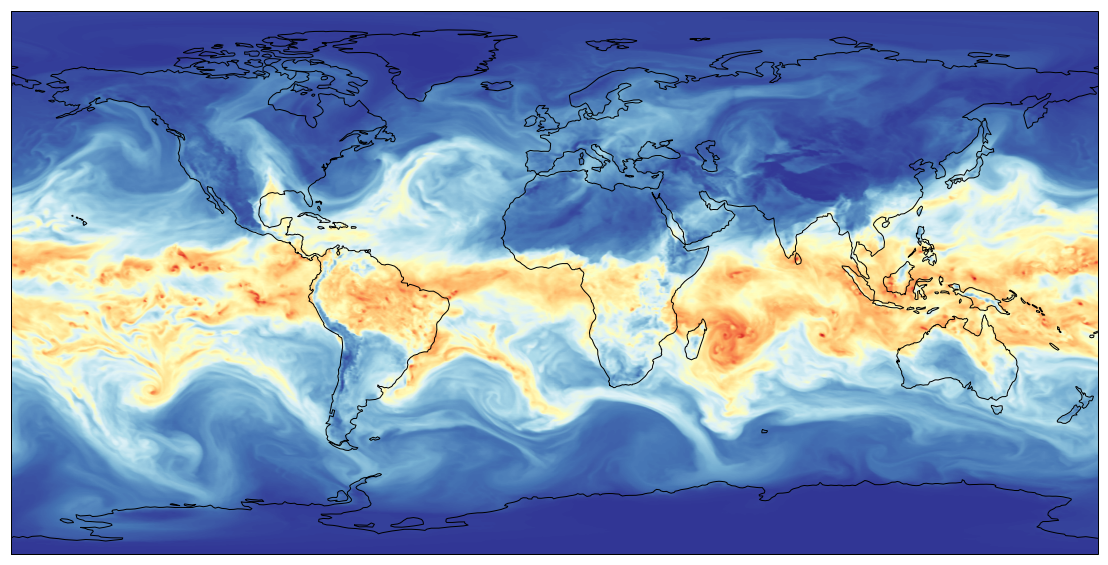

In [21]:
import tensorflow as tf
from tqdm import tqdm
from time import time

data_next = tf_local.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = training_local.N // 32 + 1
t_start = time()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    try:
        for i in tqdm(range(steps)):
#             t_begin = time()
            out = sess.run(data_next)
#             print('loop time: ', time()-t_begin)
            fig = plt.figure(figsize=(20, 10))
            ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

            ax.set_global()
            # ax.stock_img()
            ax.coastlines()

            plt.scatter(glong, glat, s=1,
                        c=out[0][0,:,:,0], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)
            break
    except tf.errors.OutOfRangeError as e:
        print("Done")
print(time()-t_start)

In [27]:
training_s3 = EquiangularDataset(path, s3=True)

In [30]:
tf_s3 = training_s3.get_dataset_s3(32)

In [31]:
import tensorflow as tf
from tqdm import tqdm
from time import time

data_next = tf_s3.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = training_s3.N // 32 + 1
t_start = time()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    try:
        for i in tqdm(range(steps)):
            t_begin = time()
            out = sess.run(data_next)
            print('loop time: ', time()-t_begin)
    except tf.errors.OutOfRangeError as e:
        print("Done")
print(time()-t_start)

time preprocess:  0.1512138843536377
time preprocess:  0.15100598335266113


  0%|          | 0/114 [00:00<?, ?it/s]

time preprocess:  0.15770792961120605
time preprocess:  0.14730620384216309
time preprocess:  0.14770793914794922
time preprocess:  0.13992571830749512
time preprocess:  0.1984846591949463
time preprocess:  0.3417787551879883
time preprocess:  0.1884918212890625
time preprocess:  0.15423297882080078
time preprocess:  0.2598378658294678
time preprocess:  0.15251493453979492
time preprocess:  0.15691018104553223
time preprocess:  0.17409181594848633
time preprocess:  0.1482408046722412
time preprocess:  0.14903664588928223
time preprocess:  0.17053937911987305
time preprocess:  0.14122819900512695
time preprocess:  0.2884688377380371
time preprocess:  0.1854238510131836
time preprocess:  0.19661784172058105
time preprocess:  0.13409137725830078
time preprocess:  0.1676769256591797
time preprocess:  0.1468353271484375
time preprocess:  0.14748787879943848
time preprocess:  0.15026402473449707
time preprocess:  0.14421439170837402
time preprocess:  0.14083337783813477
time preprocess:  0.1

  1%|          | 1/114 [01:55<3:38:00, 115.76s/it]

time preprocess:  0.15773701667785645
loop time:  115.75575375556946
time preprocess:  0.15050125122070312
time preprocess:  0.14763092994689941
time preprocess:  0.1478416919708252
time preprocess:  0.15222501754760742
time preprocess:  0.14214110374450684
time preprocess:  0.14856743812561035
time preprocess:  0.1438274383544922
time preprocess:  0.15613150596618652
time preprocess:  0.14508652687072754
time preprocess:  0.14332795143127441
time preprocess:  0.14320135116577148
time preprocess:  0.19515323638916016
time preprocess:  0.19886994361877441
time preprocess:  0.14909839630126953
time preprocess:  0.15199685096740723
time preprocess:  0.15268802642822266
time preprocess:  0.14677047729492188
time preprocess:  0.15509748458862305
time preprocess:  0.14896273612976074
time preprocess:  0.14728760719299316
time preprocess:  0.15123343467712402
time preprocess:  0.14575910568237305
time preprocess:  0.14716553688049316
time preprocess:  0.14780807495117188
time preprocess:  0.1

  2%|▏         | 2/114 [03:45<3:30:04, 112.54s/it]

time preprocess:  0.17468762397766113
loop time:  109.32904887199402
time preprocess:  0.13232421875
time preprocess:  0.2465991973876953
time preprocess:  0.25131964683532715
time preprocess:  0.14943909645080566
time preprocess:  0.1478569507598877
time preprocess:  0.14693140983581543
time preprocess:  0.1467132568359375
time preprocess:  0.14592528343200684
time preprocess:  0.14763760566711426
time preprocess:  0.14738130569458008
time preprocess:  0.14807701110839844
time preprocess:  0.15153002738952637
time preprocess:  0.1485154628753662
time preprocess:  0.1719369888305664
time preprocess:  0.15572428703308105
time preprocess:  0.15266656875610352
time preprocess:  0.1530454158782959
time preprocess:  0.15136289596557617
time preprocess:  0.15321850776672363
time preprocess:  0.15647506713867188
time preprocess:  0.1515359878540039
time preprocess:  0.1538562774658203
time preprocess:  0.16693115234375
time preprocess:  0.15638065338134766
time preprocess:  0.1517348289489746

  3%|▎         | 3/114 [05:37<3:28:03, 112.46s/it]

time preprocess:  0.15563035011291504
loop time:  112.29672384262085
time preprocess:  0.1691133975982666
time preprocess:  0.15283751487731934
time preprocess:  0.1528928279876709
time preprocess:  0.1468966007232666
time preprocess:  0.1502244472503662
time preprocess:  0.15130400657653809
time preprocess:  0.1503162384033203
time preprocess:  0.15552544593811035
time preprocess:  0.15289092063903809
time preprocess:  0.15509676933288574
time preprocess:  0.14598369598388672
time preprocess:  0.1495678424835205
time preprocess:  0.1499340534210205
time preprocess:  0.1531050205230713
time preprocess:  0.14910650253295898
time preprocess:  0.15191960334777832
time preprocess:  0.13951373100280762
time preprocess:  0.1487269401550293
time preprocess:  0.14803314208984375
time preprocess:  0.14931964874267578
time preprocess:  0.15535688400268555
time preprocess:  0.135148286819458
time preprocess:  0.17374038696289062
time preprocess:  0.13632917404174805
time preprocess:  0.1479873657

  4%|▎         | 4/114 [07:30<3:26:41, 112.74s/it]

time preprocess:  0.1518392562866211
loop time:  113.57206583023071
time preprocess:  0.17805910110473633
time preprocess:  0.15646004676818848
time preprocess:  0.1520252227783203
time preprocess:  0.14172148704528809
time preprocess:  0.1505270004272461
time preprocess:  0.14728045463562012
time preprocess:  0.1412816047668457
time preprocess:  0.14255118370056152
time preprocess:  0.13175654411315918
time preprocess:  0.17664146423339844
time preprocess:  0.1535196304321289
time preprocess:  0.17736554145812988
time preprocess:  0.1518566608428955
time preprocess:  0.14725065231323242
time preprocess:  0.15417718887329102
time preprocess:  0.15575218200683594
time preprocess:  0.15755891799926758
time preprocess:  0.18569564819335938
time preprocess:  0.16816067695617676
time preprocess:  0.15709662437438965
time preprocess:  0.1716008186340332
time preprocess:  0.1472785472869873
time preprocess:  0.1610393524169922
time preprocess:  0.14664101600646973
time preprocess:  0.14792394

  4%|▍         | 5/114 [09:34<3:28:33, 114.81s/it]

time preprocess:  0.15273642539978027
loop time:  123.06748008728027
time preprocess:  0.18692588806152344
time preprocess:  0.1515183448791504
time preprocess:  0.16083478927612305
time preprocess:  0.16383838653564453
time preprocess:  0.14754152297973633
time preprocess:  0.14879989624023438
time preprocess:  0.1454768180847168
time preprocess:  0.1454758644104004
time preprocess:  0.17191338539123535
time preprocess:  0.17765021324157715
time preprocess:  0.15323591232299805
time preprocess:  0.15447092056274414
time preprocess:  0.14720630645751953
time preprocess:  0.16988015174865723
time preprocess:  0.145890474319458
time preprocess:  0.16066575050354004
time preprocess:  0.14728093147277832
time preprocess:  0.14271163940429688
time preprocess:  0.14285516738891602
time preprocess:  0.14103293418884277
time preprocess:  0.1481308937072754
time preprocess:  0.1416640281677246
time preprocess:  0.15161347389221191
time preprocess:  0.13495540618896484
time preprocess:  0.145435

  5%|▌         | 6/114 [11:34<3:28:24, 115.78s/it]

time preprocess:  0.1491239070892334
loop time:  120.6701922416687
time preprocess:  0.1707315444946289
time preprocess:  0.14650750160217285
time preprocess:  0.14660167694091797
time preprocess:  0.16484284400939941
time preprocess:  0.1416161060333252
time preprocess:  0.15339303016662598
time preprocess:  0.1465611457824707
time preprocess:  0.14965391159057617
time preprocess:  0.17363929748535156
time preprocess:  0.14207148551940918
time preprocess:  0.14524507522583008
time preprocess:  0.14615297317504883
time preprocess:  0.1740100383758545
time preprocess:  0.14535880088806152
time preprocess:  0.17633438110351562
time preprocess:  0.15227365493774414
time preprocess:  0.15357685089111328
time preprocess:  0.17228460311889648
time preprocess:  0.14681792259216309
time preprocess:  0.13206696510314941
time preprocess:  0.1437232494354248
time preprocess:  0.13391971588134766
time preprocess:  0.14671087265014648
time preprocess:  0.1778857707977295
time preprocess:  0.1602816

  6%|▌         | 7/114 [13:27<3:25:35, 115.29s/it]

loop time:  112.32203340530396
time preprocess:  0.15499472618103027
time preprocess:  0.14732050895690918
time preprocess:  0.14381885528564453
time preprocess:  0.1524674892425537
time preprocess:  0.14158940315246582
time preprocess:  0.1482679843902588
time preprocess:  0.14995479583740234
time preprocess:  0.15175771713256836
time preprocess:  0.14779067039489746
time preprocess:  0.14475727081298828
time preprocess:  0.14760303497314453
time preprocess:  0.14737176895141602
time preprocess:  0.15137863159179688
time preprocess:  0.15176773071289062
time preprocess:  0.1528170108795166
time preprocess:  0.15276861190795898
time preprocess:  0.15019631385803223
time preprocess:  0.15137529373168945
time preprocess:  0.1465590000152588
time preprocess:  0.1530928611755371
time preprocess:  0.147507905960083
time preprocess:  0.1492936611175537
time preprocess:  0.15252017974853516
time preprocess:  0.14417791366577148
time preprocess:  0.1531221866607666
time preprocess:  0.15155434

  7%|▋         | 8/114 [15:28<3:24:58, 116.03s/it]

time preprocess:  0.14860153198242188
loop time:  121.17537498474121
time preprocess:  0.15447402000427246
time preprocess:  0.14736509323120117
time preprocess:  0.1502823829650879
time preprocess:  0.1543741226196289
time preprocess:  0.14989709854125977
time preprocess:  0.15309786796569824
time preprocess:  0.15133333206176758
time preprocess:  0.14988470077514648
time preprocess:  0.15332388877868652
time preprocess:  0.15069270133972168
time preprocess:  0.15092229843139648
time preprocess:  0.1483309268951416
time preprocess:  0.14998960494995117
time preprocess:  0.1540384292602539
time preprocess:  0.14951658248901367
time preprocess:  0.15733766555786133
time preprocess:  0.15192675590515137
time preprocess:  0.1454784870147705
time preprocess:  0.15215635299682617
time preprocess:  0.14247560501098633
time preprocess:  0.1465315818786621
time preprocess:  0.15241050720214844
time preprocess:  0.15848469734191895
time preprocess:  0.14788055419921875
time preprocess:  0.15575

  8%|▊         | 9/114 [17:29<3:24:02, 116.60s/it]

time preprocess:  0.14919614791870117
loop time:  121.16351819038391
time preprocess:  0.1487438678741455
time preprocess:  0.1295337677001953
time preprocess:  0.15345549583435059
time preprocess:  0.15112733840942383
time preprocess:  0.14428496360778809
time preprocess:  0.14741301536560059
time preprocess:  0.14705562591552734
time preprocess:  0.14950203895568848
time preprocess:  0.14795374870300293
time preprocess:  0.17963242530822754
time preprocess:  0.14716553688049316
time preprocess:  0.15314149856567383
time preprocess:  0.14725780487060547
time preprocess:  0.148209810256958
time preprocess:  0.17223334312438965
time preprocess:  0.1468822956085205
time preprocess:  0.14807462692260742
time preprocess:  0.1470334529876709
time preprocess:  0.14569473266601562
time preprocess:  0.14975929260253906
time preprocess:  0.14890336990356445
time preprocess:  0.15031719207763672
time preprocess:  0.1467912197113037
time preprocess:  0.1480724811553955
time preprocess:  0.1761577

  9%|▉         | 10/114 [19:20<3:21:10, 116.06s/it]

time preprocess:  0.15577483177185059
loop time:  111.26125383377075
time preprocess:  0.17558741569519043
time preprocess:  0.1525115966796875
time preprocess:  0.14844894409179688
time preprocess:  0.1311023235321045
time preprocess:  0.17061853408813477
time preprocess:  0.17115187644958496
time preprocess:  0.14845061302185059
time preprocess:  0.1456911563873291
time preprocess:  0.17229032516479492
time preprocess:  0.15346598625183105
time preprocess:  0.15288925170898438
time preprocess:  0.15696334838867188
time preprocess:  0.14989542961120605
time preprocess:  0.15471482276916504
time preprocess:  0.14970970153808594
time preprocess:  0.15453290939331055
time preprocess:  0.15475940704345703
time preprocess:  0.1831655502319336
time preprocess:  0.15193390846252441
time preprocess:  0.14933538436889648
time preprocess:  0.177384614944458
time preprocess:  0.14522290229797363
time preprocess:  0.15194153785705566
time preprocess:  0.14302277565002441
time preprocess:  0.14772

 10%|▉         | 11/114 [21:13<3:18:40, 115.73s/it]

time preprocess:  0.15354108810424805
loop time:  112.44265627861023
time preprocess:  0.17767930030822754
time preprocess:  0.14505410194396973
time preprocess:  0.1441023349761963
time preprocess:  0.1379413604736328
time preprocess:  0.14545702934265137
time preprocess:  0.14773297309875488
time preprocess:  0.14456844329833984
time preprocess:  0.1628856658935547
time preprocess:  0.16806936264038086
time preprocess:  0.1663837432861328
time preprocess:  0.19872808456420898
time preprocess:  0.13581442832946777
time preprocess:  0.20845746994018555
time preprocess:  0.15123438835144043
time preprocess:  0.1524975299835205
time preprocess:  0.1770639419555664
time preprocess:  0.14747834205627441
time preprocess:  0.14642858505249023
time preprocess:  0.1740865707397461
time preprocess:  0.14566779136657715
time preprocess:  0.1460564136505127
time preprocess:  0.15463709831237793
time preprocess:  0.15085554122924805
time preprocess:  0.17265939712524414
time preprocess:  0.1507372

 11%|█         | 12/114 [23:07<3:16:37, 115.66s/it]

time preprocess:  0.1743779182434082
loop time:  114.89037418365479
time preprocess:  0.1550588607788086
time preprocess:  0.15957379341125488
time preprocess:  0.15259385108947754
time preprocess:  0.14977407455444336
time preprocess:  0.14952516555786133
time preprocess:  0.14068388938903809
time preprocess:  0.1499772071838379
time preprocess:  0.14682269096374512
time preprocess:  0.146775484085083
time preprocess:  0.15101099014282227
time preprocess:  0.14698505401611328
time preprocess:  0.1501760482788086
time preprocess:  0.15566563606262207
time preprocess:  0.16670632362365723
time preprocess:  0.15213584899902344
time preprocess:  0.14779925346374512
time preprocess:  0.14762353897094727
time preprocess:  0.1521010398864746
time preprocess:  0.14974403381347656
time preprocess:  0.14858198165893555
time preprocess:  0.15021824836730957
time preprocess:  0.1503920555114746
time preprocess:  0.1524975299835205
time preprocess:  0.14953041076660156
time preprocess:  0.13089656

 11%|█▏        | 13/114 [25:03<3:14:42, 115.67s/it]

time preprocess:  0.15054726600646973
loop time:  115.72899222373962
time preprocess:  0.14707517623901367
time preprocess:  0.14567327499389648
time preprocess:  0.15188336372375488
time preprocess:  0.14899420738220215
time preprocess:  0.14740753173828125
time preprocess:  0.1553335189819336
time preprocess:  0.14942312240600586
time preprocess:  0.15351176261901855
time preprocess:  0.14870500564575195
time preprocess:  0.1531519889831543
time preprocess:  0.14903521537780762
time preprocess:  0.15290451049804688
time preprocess:  0.14819931983947754
time preprocess:  0.14966511726379395
time preprocess:  0.15067505836486816
time preprocess:  0.1498115062713623
time preprocess:  0.15134477615356445
time preprocess:  0.1478743553161621
time preprocess:  0.14804291725158691
time preprocess:  0.14769554138183594
time preprocess:  0.14776349067687988
time preprocess:  0.14545488357543945
time preprocess:  0.13829326629638672
time preprocess:  0.12761878967285156
time preprocess:  0.132

 12%|█▏        | 14/114 [27:01<3:13:01, 115.81s/it]

time preprocess:  0.1536250114440918
loop time:  117.68122577667236
time preprocess:  0.17426705360412598
time preprocess:  0.14654183387756348
time preprocess:  0.15293455123901367
time preprocess:  0.1406693458557129
time preprocess:  0.13820338249206543
time preprocess:  0.1492605209350586
time preprocess:  0.13977384567260742
time preprocess:  0.14788579940795898
time preprocess:  0.14374279975891113
time preprocess:  0.1476917266845703
time preprocess:  0.1446242332458496
time preprocess:  0.14328646659851074
time preprocess:  0.14092731475830078
time preprocess:  0.1409602165222168
time preprocess:  0.14629101753234863
time preprocess:  0.14484691619873047
time preprocess:  0.1350257396697998
time preprocess:  0.14224720001220703
time preprocess:  0.1503462791442871
time preprocess:  0.1465163230895996
time preprocess:  0.14679765701293945
time preprocess:  0.15169692039489746
time preprocess:  0.14968276023864746
time preprocess:  0.14882659912109375
time preprocess:  0.14490389

 13%|█▎        | 15/114 [28:56<3:10:58, 115.75s/it]

time preprocess:  0.15386652946472168
loop time:  114.78970003128052
time preprocess:  0.17640447616577148
time preprocess:  0.15199542045593262
time preprocess:  0.14479851722717285
time preprocess:  0.15041112899780273
time preprocess:  0.17360258102416992
time preprocess:  0.1468651294708252
time preprocess:  0.14234519004821777
time preprocess:  0.15476536750793457
time preprocess:  0.1494612693786621
time preprocess:  0.15021729469299316
time preprocess:  0.1744241714477539
time preprocess:  0.1484231948852539
time preprocess:  0.14786648750305176
time preprocess:  0.17188596725463867
time preprocess:  0.14724493026733398
time preprocess:  0.15393519401550293
time preprocess:  0.14606904983520508
time preprocess:  0.14093542098999023
time preprocess:  0.17860651016235352
time preprocess:  0.16092300415039062
time preprocess:  0.14146661758422852
time preprocess:  0.14514899253845215
time preprocess:  0.14598298072814941
time preprocess:  0.1400620937347412
time preprocess:  0.1488

 14%|█▍        | 16/114 [30:43<3:08:10, 115.21s/it]

time preprocess:  0.15528392791748047
loop time:  107.21797394752502
time preprocess:  0.16705083847045898
time preprocess:  0.14658761024475098
time preprocess:  0.14899682998657227
time preprocess:  0.1325209140777588
time preprocess:  0.1433577537536621
time preprocess:  0.1573622226715088
time preprocess:  0.1456599235534668
time preprocess:  0.13498497009277344
time preprocess:  0.14777445793151855
time preprocess:  0.14221715927124023
time preprocess:  0.16150450706481934
time preprocess:  0.17295050621032715
time preprocess:  0.14389824867248535
time preprocess:  0.1658015251159668
time preprocess:  0.14039134979248047
time preprocess:  0.1430037021636963
time preprocess:  0.13950300216674805
time preprocess:  0.14220690727233887
time preprocess:  0.16942191123962402
time preprocess:  0.14378046989440918
time preprocess:  0.16883182525634766
time preprocess:  0.1519758701324463
time preprocess:  0.14869046211242676
time preprocess:  0.14999842643737793
time preprocess:  0.151477

 15%|█▍        | 17/114 [32:43<3:06:41, 115.48s/it]

time preprocess:  0.15730643272399902
loop time:  119.73473525047302
time preprocess:  0.1463792324066162
time preprocess:  0.14762520790100098
time preprocess:  0.13387417793273926
time preprocess:  0.13427019119262695
time preprocess:  0.13218927383422852
time preprocess:  0.1404743194580078
time preprocess:  0.14797425270080566
time preprocess:  0.14144492149353027
time preprocess:  0.16902422904968262
time preprocess:  0.14669466018676758
time preprocess:  0.15755844116210938
time preprocess:  0.14223766326904297
time preprocess:  0.14879107475280762
time preprocess:  0.14480829238891602
time preprocess:  0.13941383361816406
time preprocess:  0.1457045078277588
time preprocess:  0.14960479736328125
time preprocess:  0.15050935745239258
time preprocess:  0.15289044380187988
time preprocess:  0.14605212211608887
time preprocess:  0.14558649063110352
time preprocess:  0.15334057807922363
time preprocess:  0.14920997619628906
time preprocess:  0.1482086181640625
time preprocess:  0.139

 16%|█▌        | 18/114 [34:42<3:05:07, 115.70s/it]

time preprocess:  0.1461799144744873
loop time:  119.46596884727478
time preprocess:  0.15103507041931152
time preprocess:  0.14899826049804688
time preprocess:  0.15494585037231445
time preprocess:  0.14965200424194336
time preprocess:  0.1509842872619629
time preprocess:  0.14846348762512207
time preprocess:  0.1508021354675293
time preprocess:  0.15586233139038086
time preprocess:  0.14824819564819336
time preprocess:  0.1325702667236328
time preprocess:  0.13275384902954102
time preprocess:  0.1486492156982422
time preprocess:  0.1468186378479004
time preprocess:  0.1450049877166748
time preprocess:  0.14952754974365234
time preprocess:  0.1544935703277588
time preprocess:  0.15113425254821777
time preprocess:  0.17833900451660156
time preprocess:  0.1769571304321289
time preprocess:  0.15086889266967773
time preprocess:  0.14561748504638672
time preprocess:  0.14349675178527832
time preprocess:  0.14064455032348633
time preprocess:  0.15011262893676758
time preprocess:  0.14340305

 17%|█▋        | 19/114 [36:59<3:04:56, 116.80s/it]

time preprocess:  0.15223073959350586
loop time:  136.66857051849365
time preprocess:  0.15796542167663574
time preprocess:  0.15182733535766602
time preprocess:  0.15363669395446777
time preprocess:  0.15128469467163086
time preprocess:  0.1514573097229004
time preprocess:  0.15241074562072754
time preprocess:  0.15224480628967285
time preprocess:  0.1568739414215088
time preprocess:  0.15149593353271484
time preprocess:  0.16602158546447754
time preprocess:  0.15473437309265137
time preprocess:  0.1550595760345459
time preprocess:  0.15717053413391113
time preprocess:  0.15456080436706543
time preprocess:  0.15584087371826172
time preprocess:  0.15134644508361816
time preprocess:  0.15230917930603027
time preprocess:  0.15270328521728516
time preprocess:  0.15767407417297363
time preprocess:  0.15791034698486328
time preprocess:  0.15492987632751465
time preprocess:  0.16997313499450684
time preprocess:  0.15580272674560547
time preprocess:  0.1347513198852539
time preprocess:  0.132

 18%|█▊        | 20/114 [39:03<3:03:36, 117.20s/it]

time preprocess:  0.14568567276000977
loop time:  124.6572732925415
time preprocess:  0.15651178359985352
time preprocess:  0.15883398056030273
time preprocess:  0.1574411392211914
time preprocess:  0.15665102005004883
time preprocess:  0.15392756462097168
time preprocess:  0.15502405166625977
time preprocess:  0.15625715255737305
time preprocess:  0.15459656715393066
time preprocess:  0.15821075439453125
time preprocess:  0.1507260799407959
time preprocess:  0.1564793586730957
time preprocess:  0.14830851554870605
time preprocess:  0.1602485179901123
time preprocess:  0.1551210880279541
time preprocess:  0.15491771697998047
time preprocess:  0.1531848907470703
time preprocess:  0.15569448471069336
time preprocess:  0.1510310173034668
time preprocess:  0.14577126502990723
time preprocess:  0.14746975898742676
time preprocess:  0.14829134941101074
time preprocess:  0.14970040321350098
time preprocess:  0.15950608253479004
time preprocess:  0.15525603294372559
time preprocess:  0.1352491

 18%|█▊        | 21/114 [40:53<3:01:06, 116.85s/it]

time preprocess:  0.1817610263824463
loop time:  109.8942084312439
time preprocess:  0.23718547821044922
time preprocess:  0.16211605072021484
time preprocess:  0.18058395385742188
time preprocess:  0.1601095199584961
time preprocess:  0.1541459560394287
time preprocess:  0.15001583099365234
time preprocess:  0.14925551414489746
time preprocess:  0.15055012702941895
time preprocess:  0.15311050415039062
time preprocess:  0.15029692649841309
time preprocess:  0.1502242088317871
time preprocess:  0.16332602500915527
time preprocess:  0.1511402130126953
time preprocess:  0.1431257724761963
time preprocess:  0.1514735221862793
time preprocess:  0.14400768280029297
time preprocess:  0.15143251419067383
time preprocess:  0.15298938751220703
time preprocess:  0.1588273048400879
time preprocess:  0.15989351272583008
time preprocess:  0.15752553939819336
time preprocess:  0.1850738525390625
time preprocess:  0.14302849769592285
time preprocess:  0.15741300582885742
time preprocess:  0.161438465

 19%|█▉        | 22/114 [42:50<2:59:08, 116.83s/it]

time preprocess:  0.17139840126037598
loop time:  116.36922669410706
time preprocess:  0.17275047302246094
time preprocess:  0.16970133781433105
time preprocess:  0.15480279922485352
time preprocess:  0.15118646621704102
time preprocess:  0.15221834182739258
time preprocess:  0.15193438529968262
time preprocess:  0.15418601036071777
time preprocess:  0.15136265754699707
time preprocess:  0.1577463150024414
time preprocess:  0.1485118865966797
time preprocess:  0.16232728958129883
time preprocess:  0.16422557830810547
time preprocess:  0.15941643714904785
time preprocess:  0.1622791290283203
time preprocess:  0.1566448211669922
time preprocess:  0.15890765190124512
time preprocess:  0.1639111042022705
time preprocess:  0.16065001487731934
time preprocess:  0.16408944129943848
time preprocess:  0.15942645072937012
time preprocess:  0.15376067161560059
time preprocess:  0.15068435668945312
time preprocess:  0.15173125267028809
time preprocess:  0.15633869171142578
time preprocess:  0.1551

 20%|██        | 23/114 [44:42<2:56:54, 116.65s/it]

time preprocess:  0.1456165313720703
loop time:  112.6516785621643
time preprocess:  0.15845513343811035
time preprocess:  0.1640605926513672
time preprocess:  0.15647649765014648
time preprocess:  0.15410995483398438
time preprocess:  0.1595015525817871
time preprocess:  0.15924787521362305
time preprocess:  0.14636993408203125
time preprocess:  0.1407766342163086
time preprocess:  0.16051173210144043
time preprocess:  0.16250944137573242
time preprocess:  0.16191363334655762
time preprocess:  0.1551954746246338
time preprocess:  0.14980649948120117
time preprocess:  0.16512227058410645
time preprocess:  0.1509397029876709
time preprocess:  0.15998458862304688
time preprocess:  0.15484309196472168
time preprocess:  0.16088271141052246
time preprocess:  0.16034984588623047
time preprocess:  0.1607654094696045
time preprocess:  0.16025638580322266
time preprocess:  0.16266083717346191
time preprocess:  0.1607518196105957
time preprocess:  0.1585984230041504
time preprocess:  0.161216497

 21%|██        | 24/114 [47:07<2:56:41, 117.80s/it]

time preprocess:  0.13628149032592773
loop time:  144.2507963180542
time preprocess:  0.1986837387084961
time preprocess:  0.1559162139892578
time preprocess:  0.16029095649719238
time preprocess:  0.14345908164978027
time preprocess:  0.16034889221191406
time preprocess:  0.15986013412475586
time preprocess:  0.15674090385437012
time preprocess:  0.16006779670715332
time preprocess:  0.16208553314208984
time preprocess:  0.1642923355102539
time preprocess:  0.16264772415161133
time preprocess:  0.15603256225585938
time preprocess:  0.1707930564880371
time preprocess:  0.16077303886413574
time preprocess:  0.16709280014038086
time preprocess:  0.16558313369750977
time preprocess:  0.16371369361877441
time preprocess:  0.16276216506958008
time preprocess:  0.1513829231262207
time preprocess:  0.16267728805541992
time preprocess:  0.1650223731994629
time preprocess:  0.16346192359924316
time preprocess:  0.16080307960510254
time preprocess:  0.16133928298950195
time preprocess:  0.167853

 22%|██▏       | 25/114 [49:13<2:55:13, 118.12s/it]

time preprocess:  0.15703725814819336
loop time:  125.9936375617981
time preprocess:  0.16493844985961914
time preprocess:  0.16124391555786133
time preprocess:  0.15928220748901367
time preprocess:  0.16172385215759277
time preprocess:  0.15951204299926758
time preprocess:  0.16054987907409668
time preprocess:  0.17240643501281738
time preprocess:  0.17138051986694336
time preprocess:  0.15166497230529785
time preprocess:  0.1710205078125
time preprocess:  0.1683492660522461
time preprocess:  0.17385053634643555
time preprocess:  0.18299198150634766
time preprocess:  0.17205405235290527
time preprocess:  0.16907477378845215
time preprocess:  0.17117881774902344
time preprocess:  0.16742825508117676
time preprocess:  0.18927955627441406
time preprocess:  0.17056894302368164
time preprocess:  0.17018508911132812
time preprocess:  0.16607403755187988
time preprocess:  0.1685504913330078
time preprocess:  0.16844677925109863
time preprocess:  0.1754918098449707
time preprocess:  0.1688613

 23%|██▎       | 26/114 [51:04<2:52:52, 117.87s/it]

time preprocess:  0.16083025932312012
loop time:  111.5919668674469
time preprocess:  0.15329456329345703
time preprocess:  0.1976325511932373
time preprocess:  0.1789393424987793
time preprocess:  0.16914606094360352
time preprocess:  0.1704709529876709
time preprocess:  0.16828322410583496
time preprocess:  0.1726086139678955
time preprocess:  0.17518925666809082
time preprocess:  0.1812291145324707
time preprocess:  0.1570439338684082
time preprocess:  0.15410995483398438
time preprocess:  0.15443682670593262
time preprocess:  0.15278100967407227
time preprocess:  0.16158318519592285
time preprocess:  0.15579605102539062
time preprocess:  0.15932655334472656
time preprocess:  0.15722036361694336
time preprocess:  0.1591193675994873
time preprocess:  0.16243433952331543
time preprocess:  0.1564483642578125
time preprocess:  0.16004037857055664
time preprocess:  0.15692925453186035
time preprocess:  0.15529179573059082
time preprocess:  0.15713095664978027
time preprocess:  0.15649342

 24%|██▎       | 27/114 [52:59<2:50:44, 117.75s/it]

time preprocess:  0.15308642387390137
loop time:  114.61482882499695
time preprocess:  0.16589045524597168
time preprocess:  0.15120887756347656
time preprocess:  0.15136432647705078
time preprocess:  0.1574420928955078
time preprocess:  0.16206097602844238
time preprocess:  0.1575016975402832
time preprocess:  0.16167044639587402
time preprocess:  0.1561734676361084
time preprocess:  0.15883183479309082
time preprocess:  0.1533362865447998
time preprocess:  0.15594100952148438
time preprocess:  0.15543794631958008
time preprocess:  0.15866327285766602
time preprocess:  0.1537182331085205
time preprocess:  0.15862011909484863
time preprocess:  0.15743112564086914
time preprocess:  0.15816092491149902
time preprocess:  0.15287256240844727
time preprocess:  0.15053701400756836
time preprocess:  0.15421748161315918
time preprocess:  0.15210509300231934
time preprocess:  0.15453696250915527
time preprocess:  0.15229082107543945
time preprocess:  0.15088319778442383
time preprocess:  0.1564

 25%|██▍       | 28/114 [54:56<2:48:46, 117.74s/it]

time preprocess:  0.14905452728271484
loop time:  117.54040050506592
time preprocess:  0.15564203262329102
time preprocess:  0.16233491897583008
time preprocess:  0.1541156768798828
time preprocess:  0.15675616264343262
time preprocess:  0.15213608741760254
time preprocess:  0.18032240867614746
time preprocess:  0.18088579177856445
time preprocess:  0.15207815170288086
time preprocess:  0.1578083038330078
time preprocess:  0.14418792724609375
time preprocess:  0.15499496459960938
time preprocess:  0.15440893173217773
time preprocess:  0.15651535987854004
time preprocess:  0.15431833267211914
time preprocess:  0.15727806091308594
time preprocess:  0.15848779678344727
time preprocess:  0.1555027961730957
time preprocess:  0.17804312705993652
time preprocess:  0.16263818740844727
time preprocess:  0.16372251510620117
time preprocess:  0.15254449844360352
time preprocess:  0.15755558013916016
time preprocess:  0.15646767616271973
time preprocess:  0.1530163288116455
time preprocess:  0.152

 25%|██▌       | 29/114 [57:00<2:47:05, 117.94s/it]

time preprocess:  0.1559009552001953
loop time:  123.50533294677734
time preprocess:  0.15996050834655762
time preprocess:  0.15971803665161133
time preprocess:  0.15957951545715332
time preprocess:  0.17192769050598145
time preprocess:  0.15497088432312012
time preprocess:  0.16002559661865234
time preprocess:  0.15765738487243652
time preprocess:  0.16218876838684082
time preprocess:  0.1579136848449707
time preprocess:  0.15719056129455566
time preprocess:  0.15896844863891602
time preprocess:  0.158247709274292
time preprocess:  0.15491771697998047
time preprocess:  0.15456748008728027
time preprocess:  0.15295195579528809
time preprocess:  0.15472912788391113
time preprocess:  0.15477657318115234
time preprocess:  0.15755438804626465
time preprocess:  0.15363335609436035
time preprocess:  0.1522970199584961
time preprocess:  0.18103981018066406
time preprocess:  0.15717267990112305
time preprocess:  0.18006610870361328
time preprocess:  0.15917658805847168
time preprocess:  0.1573

 26%|██▋       | 30/114 [59:13<2:45:50, 118.46s/it]

time preprocess:  0.15556097030639648
loop time:  133.5429985523224
time preprocess:  0.15595245361328125
time preprocess:  0.15668487548828125
time preprocess:  0.15813541412353516
time preprocess:  0.15267491340637207
time preprocess:  0.16025733947753906
time preprocess:  0.1560962200164795
time preprocess:  0.15239596366882324
time preprocess:  0.15485644340515137
time preprocess:  0.15283846855163574
time preprocess:  0.15073347091674805
time preprocess:  0.1549680233001709
time preprocess:  0.1512622833251953
time preprocess:  0.158372163772583
time preprocess:  0.14943814277648926
time preprocess:  0.15256571769714355
time preprocess:  0.15530681610107422
time preprocess:  0.1386122703552246
time preprocess:  0.1416473388671875
time preprocess:  0.152740478515625
time preprocess:  0.15038490295410156
time preprocess:  0.15496492385864258
time preprocess:  0.1485276222229004
time preprocess:  0.15446019172668457
time preprocess:  0.15824222564697266
time preprocess:  0.1570611000

 27%|██▋       | 31/114 [1:01:17<2:44:06, 118.64s/it]

time preprocess:  0.15169644355773926
loop time:  123.84926581382751
time preprocess:  0.160963773727417
time preprocess:  0.16204166412353516
time preprocess:  0.15526318550109863
time preprocess:  0.1607227325439453
time preprocess:  0.1561427116394043
time preprocess:  0.1594071388244629
time preprocess:  0.15738844871520996
time preprocess:  0.16042423248291016
time preprocess:  0.16166448593139648
time preprocess:  0.15879201889038086
time preprocess:  0.15726852416992188
time preprocess:  0.17213678359985352
time preprocess:  0.15684294700622559
time preprocess:  0.1551826000213623
time preprocess:  0.1606893539428711
time preprocess:  0.1520371437072754
time preprocess:  0.1535634994506836
time preprocess:  0.15778446197509766
time preprocess:  0.17336487770080566
time preprocess:  0.1608870029449463
time preprocess:  0.1589052677154541
time preprocess:  0.16038918495178223
time preprocess:  0.1565253734588623
time preprocess:  0.15205812454223633
time preprocess:  0.15884256362

 28%|██▊       | 32/114 [1:03:21<2:42:20, 118.78s/it]

time preprocess:  0.1540987491607666
loop time:  123.29217386245728
time preprocess:  0.160353422164917
time preprocess:  0.1590437889099121
time preprocess:  0.15264153480529785
time preprocess:  0.1544630527496338
time preprocess:  0.15590429306030273
time preprocess:  0.1566147804260254
time preprocess:  0.1574110984802246
time preprocess:  0.15479159355163574
time preprocess:  0.15799236297607422
time preprocess:  0.16568613052368164
time preprocess:  0.15628337860107422
time preprocess:  0.16153526306152344
time preprocess:  0.15903949737548828
time preprocess:  0.15675902366638184
time preprocess:  0.17055153846740723
time preprocess:  0.15398597717285156
time preprocess:  0.16616201400756836
time preprocess:  0.1600351333618164
time preprocess:  0.16075444221496582
time preprocess:  0.16045236587524414
time preprocess:  0.15892863273620605
time preprocess:  0.17063665390014648
time preprocess:  0.15669679641723633
time preprocess:  0.15528178215026855
time preprocess:  0.1544890

 29%|██▉       | 33/114 [1:05:18<2:40:17, 118.73s/it]

time preprocess:  0.12895584106445312
loop time:  117.15536689758301
time preprocess:  0.16841340065002441
time preprocess:  0.15524649620056152
time preprocess:  0.1593925952911377
time preprocess:  0.1605691909790039
time preprocess:  0.15809130668640137
time preprocess:  0.160689115524292
time preprocess:  0.15165281295776367
time preprocess:  0.18669533729553223
time preprocess:  0.15602970123291016
time preprocess:  0.15557408332824707
time preprocess:  0.13515520095825195
time preprocess:  0.17848777770996094
time preprocess:  0.15781474113464355
time preprocess:  0.16090917587280273
time preprocess:  0.15388894081115723
time preprocess:  0.16222572326660156
time preprocess:  0.15396571159362793
time preprocess:  0.15122485160827637
time preprocess:  0.15824508666992188
time preprocess:  0.15416169166564941
time preprocess:  0.1512455940246582
time preprocess:  0.15361332893371582
time preprocess:  0.16854524612426758
time preprocess:  0.1725001335144043
time preprocess:  0.15595

 30%|██▉       | 34/114 [1:07:11<2:38:05, 118.57s/it]

time preprocess:  0.15092253684997559
loop time:  113.05589938163757
time preprocess:  0.161818265914917
time preprocess:  0.15259242057800293
time preprocess:  0.1619575023651123
time preprocess:  0.16076111793518066
time preprocess:  0.15616750717163086
time preprocess:  0.15770435333251953
time preprocess:  0.16803312301635742
time preprocess:  0.1525411605834961
time preprocess:  0.15387797355651855
time preprocess:  0.1596074104309082
time preprocess:  0.15709757804870605
time preprocess:  0.15577983856201172
time preprocess:  0.14867806434631348
time preprocess:  0.14011430740356445
time preprocess:  0.17343521118164062
time preprocess:  0.14365530014038086
time preprocess:  0.15905094146728516
time preprocess:  0.14958596229553223
time preprocess:  0.15561199188232422
time preprocess:  0.16670465469360352
time preprocess:  0.176863431930542
time preprocess:  0.14974188804626465
time preprocess:  0.1503136157989502
time preprocess:  0.16586565971374512
time preprocess:  0.1495292

 31%|███       | 35/114 [1:09:23<2:36:36, 118.95s/it]

time preprocess:  0.15553975105285645
loop time:  131.88448309898376
time preprocess:  0.15727019309997559
time preprocess:  0.1677227020263672
time preprocess:  0.15134406089782715
time preprocess:  0.1572103500366211
time preprocess:  0.15619540214538574
time preprocess:  0.15752625465393066
time preprocess:  0.16930389404296875
time preprocess:  0.16097044944763184
time preprocess:  0.1635127067565918
time preprocess:  0.15850543975830078
time preprocess:  0.15786457061767578
time preprocess:  0.15279912948608398
time preprocess:  0.13872218132019043
time preprocess:  0.15439558029174805
time preprocess:  0.18531179428100586
time preprocess:  0.1495215892791748
time preprocess:  0.1628737449645996
time preprocess:  0.15439200401306152
time preprocess:  0.15161466598510742
time preprocess:  0.1455554962158203
time preprocess:  0.16855788230895996
time preprocess:  0.15317058563232422
time preprocess:  0.15856075286865234
time preprocess:  0.1818375587463379
time preprocess:  0.161734

 32%|███▏      | 36/114 [1:11:16<2:34:25, 118.79s/it]

time preprocess:  0.17823433876037598
loop time:  113.16612529754639
time preprocess:  0.19268059730529785
time preprocess:  0.16490697860717773
time preprocess:  0.15735340118408203
time preprocess:  0.15781068801879883
time preprocess:  0.15002846717834473
time preprocess:  0.15814948081970215
time preprocess:  0.1534428596496582
time preprocess:  0.15731525421142578
time preprocess:  0.16196846961975098
time preprocess:  0.15700244903564453
time preprocess:  0.16306638717651367
time preprocess:  0.15833640098571777
time preprocess:  0.16196060180664062
time preprocess:  0.15933966636657715
time preprocess:  0.1588306427001953
time preprocess:  0.16158604621887207
time preprocess:  0.15963053703308105
time preprocess:  0.16439032554626465
time preprocess:  0.1589810848236084
time preprocess:  0.15749764442443848
time preprocess:  0.16219019889831543
time preprocess:  0.16054749488830566
time preprocess:  0.15778064727783203
time preprocess:  0.16100788116455078
time preprocess:  0.15

 32%|███▏      | 37/114 [1:13:11<2:32:19, 118.70s/it]

loop time:  115.46804118156433
time preprocess:  0.17026185989379883
time preprocess:  0.15932631492614746
time preprocess:  0.16040945053100586
time preprocess:  0.15813207626342773
time preprocess:  0.15659499168395996
time preprocess:  0.1614518165588379
time preprocess:  0.15742826461791992
time preprocess:  0.15843987464904785
time preprocess:  0.17433953285217285
time preprocess:  0.17615509033203125
time preprocess:  0.15384554862976074
time preprocess:  0.1484534740447998
time preprocess:  0.15843772888183594
time preprocess:  0.15353703498840332
time preprocess:  0.16167259216308594
time preprocess:  0.15787124633789062
time preprocess:  0.15800142288208008
time preprocess:  0.17342567443847656
time preprocess:  0.17403697967529297
time preprocess:  0.1756894588470459
time preprocess:  0.15166926383972168
time preprocess:  0.15123844146728516
time preprocess:  0.15988445281982422
time preprocess:  0.17368721961975098
time preprocess:  0.1617569923400879
time preprocess:  0.159

KeyboardInterrupt: 

time preprocess:  0.16011285781860352


In [38]:
from tensorflow.python.lib.io import file_io
gstats = file_io.stat('s3://10380-903b2ba14e0d980c25436f9ca5bb29f5/Datasets/Climate/data-2106-02-23-03-1.h5')

In [42]:
gstats.length

60171866

## Training

In [10]:
EXP_NAME = 'TestClimate_resume'

In [13]:
(bw1, bw2) = (384, 576)

In [17]:
import tensorflow as tf
params = {'nsides': [5, 5, 4, 3, 2, 1, 0, 0],
          'F': [32, 64, 128, 256, 512, 512, 512],#np.max(labels_train).astype(int)+1],
          'K': [4]*7,
          'batch_norm': [True]*7}
params['sampling'] = 'icosahedron'
params['dir_name'] = EXP_NAME
params['num_feat_in'] = 16 # x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 25  # Number of passes through the training data.
params['batch_size'] = 32
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
# params['optimizer'] = lambda lr: tf.train.AdamOptimizer(lr, beta1=0.9, beta2=0.999, epsilon=1e-8)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 100
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = 3 # np.max(labels_train).astype(int)+1
params['dense'] = True
params['tf_dataset'] = training.get_tf_dataset(params['batch_size'])
# params['profile'] = True

In [11]:
import tensorflow as tf
params = {'nsides': [5, 5, 4, 3],
          'F': [32, 64, 128],#np.max(labels_train).astype(int)+1],
          'K': [4]*3,
          'batch_norm': [True]*3}
params['sampling'] = 'icosahedron'
params['dir_name'] = EXP_NAME
params['num_feat_in'] = 16 # x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 2  # Number of passes through the training data.
params['batch_size'] = 64
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
# params['optimizer'] = lambda lr: tf.train.AdamOptimizer(lr, beta1=0.9, beta2=0.999, epsilon=1e-8)
params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 128
params['eval_frequency'] = int(params['num_epochs'] * (training.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = 3 # np.max(labels_train).astype(int)+1
params['dense'] = True
params['tf_dataset'] = training.get_tf_dataset(params['batch_size'])
# params['profile'] = True

In [13]:
EXP_NAME = "TestClimate_pooling_weight_equi"

In [35]:
# Cleanup before running again.
shutil.rmtree('../../summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('../../checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

In [15]:
import tensorflow as tf
params = {'nsides': [(bw1, bw2), (bw1, bw2),(bw1//4, bw2//4),(bw1//16, bw2//16),(bw1//16, bw2//16)],
          'F': [8, 32, 64, 128],#np.max(labels_train).astype(int)+1],
          'K': [5]*4,
          'batch_norm': [True]*4}
params['sampling'] = 'equiangular'
params['dir_name'] = EXP_NAME
params['num_feat_in'] = 16 # x_train.shape[-1] # 2*days_pred+3
params['conv'] = 'chebyshev5'
params['pool'] = 'average'
params['activation'] = 'relu'
params['statistics'] = None#'mean'
params['regularization'] = 0
params['dropout'] = 1
params['num_epochs'] = 25  # Number of passes through the training data.
params['batch_size'] = 1
params['scheduler'] = lambda step: tf.train.exponential_decay(1e-3, step, decay_steps=2000, decay_rate=1)
#params['optimizer'] = lambda lr: tf.train.GradientDescentOptimizer(lr)
params['optimizer'] = lambda lr: tf.train.AdamOptimizer(lr, beta1=0.9, beta2=0.999, epsilon=1e-8)
# params['optimizer'] = lambda lr: tf.train.RMSPropOptimizer(lr, decay=0.9, momentum=0.)
n_evaluations = 100
params['eval_frequency'] = int(params['num_epochs'] * (training_local.N) / params['batch_size'] / n_evaluations)
params['M'] = []
params['Fseg'] = 3 # np.max(labels_train).astype(int)+1
params['dense'] = True
params['tf_dataset'] = training_local.get_tf_dataset(params['batch_size'])

In [12]:
# print([12*nside**2 for nside in params['nsides']])
model = models.deepsphere(**params)

build laplacian, time:  0.15443110466003418
rescale laplacian, time:  0.5173876285552979
build laplacian, time:  0.5629355907440186
rescale laplacian, time:  0.6377851963043213
NN architecture
  input: M_0 = 10242
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 10242 * 32 / 10242 = 32
    weights: F_0 * F_1 * K_1 = 16 * 32 * 4 = 2048
    biases: F_1 = 32
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 10242 * 64 / 2562 = 255
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 2562 * 128 / 642 = 510
    weights: F_2 * F_3 * K_3 = 64 * 128 * 4 = 32768
    batch normalization
data iterator inst., time:  0.1798384189605713
inputs, time:  0.18392705917358398
filter0, time:  0.047896385192871094
bn0, time:  0.14333581924438477
relu0, time:  0.15398693084716797
pooling0, time:  0.15851712226867676
filter1, time:  0.22011899948120117
bn1, time:  0.315485

Jiang: 328,339

DeepSphere ico deep: 12,926,432

DeepSphere ico shallowe: 141,624

DeepSphere equi: z

In [31]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0 2048
conv1/bias:0 32
conv2/weights:0 8192
conv2/bias:0 64
conv3/weights:0 32768
upconv2/weights:0 65536
upconv2/bias:0 128
deconv2/weights:0 98304
deconv2/bias:0 128
upconv1/weights:0 32768
upconv1/bias:0 64
deconv1/weights:0 24576
deconv1/bias:0 64
deconv0/weights:0 8192
deconv0/bias:0 32
outconv/weights:0 96
the number of parameters in the model is: 272,992


In [ ]:
model.fit(training, validation, use_tf_dataset=True, cache='TF', restore=True)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/TestClimate_resume/model-520
[0.10139398]
[0.10358998]
step 530 / 1372 (epoch 0.77 / 2):
  learning_rate = 1.00e-03, training mAP = 0.00, training loss = 7.56e-02
  validation 
  CPU time: 17s, wall time: 20s, perf_time_load: 1.538s, perf_time: 1.538s
step 540 / 1372 (epoch 0.79 / 2):
  learning_rate = 1.00e-03, training mAP = 0.00, training loss = 6.95e-02
  validation 
  CPU time: 29s, wall time: 40s, perf_time_load: 1.538s, perf_time: 1.538s


In [43]:
predictions = model.predict(x_test)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/TestClimate_complete_pooling_weight/model-123480


In [44]:
probabilities = model.probs(x_test, 3)

INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/TestClimate_complete_pooling_weight/model-123480


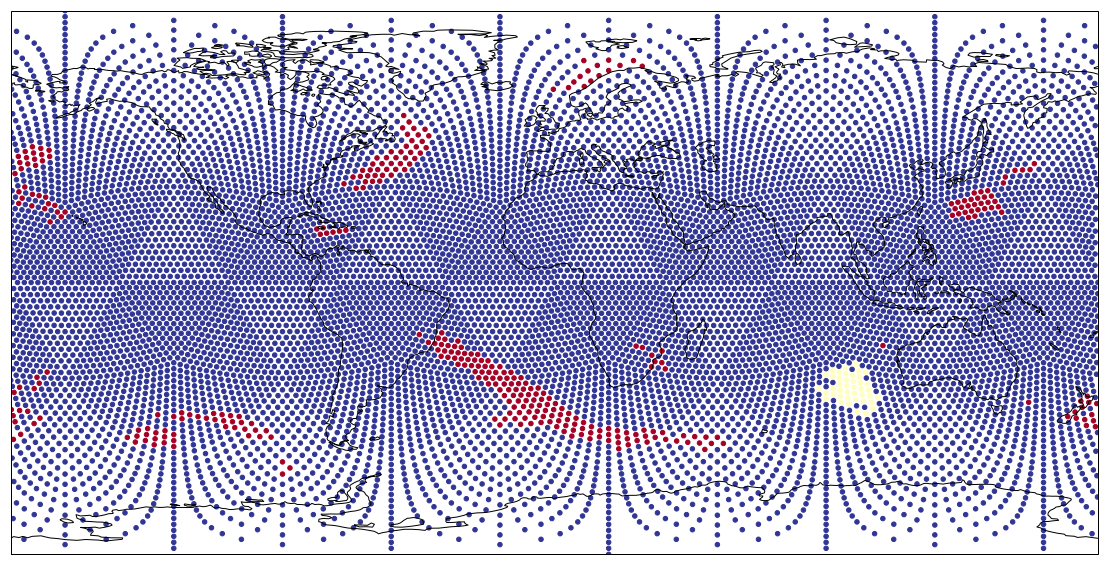

In [45]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=predictions[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

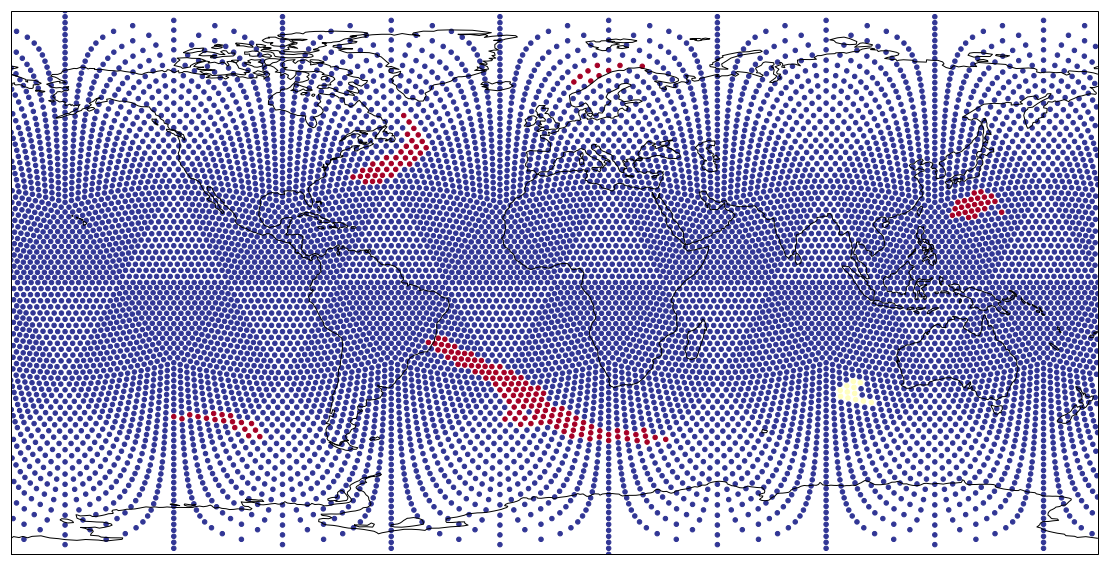

In [46]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_global()
# ax.stock_img()
ax.coastlines()

plt.scatter(icolong, icolat, s=20,
            c=labels_test[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1)

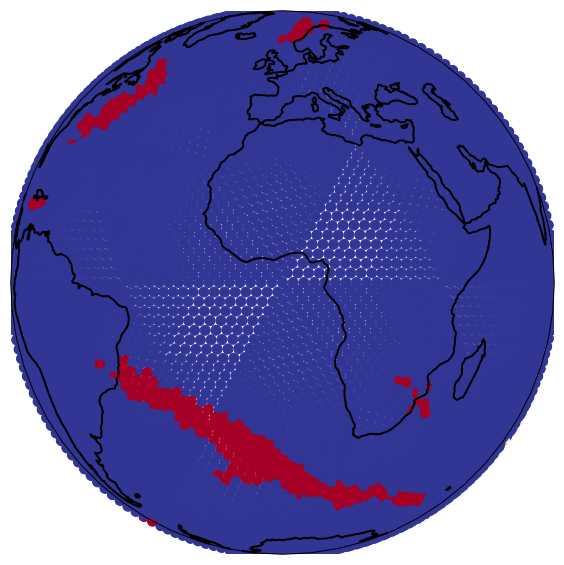

In [47]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(0, 0))
ax.set_global()
ax.coastlines(linewidth=2)

# zmin, zmax = -20, 40

plt.scatter(icolong, icolat, s=100,
            c=predictions[0,:], cmap=plt.get_cmap('RdYlBu_r'), alpha=1, transform=ccrs.PlateCarree())

In [48]:
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.preprocessing import label_binarize

In [49]:
def accuracy(pred_cls, true_cls, nclass=3):
    accu = []
    tot_int = 0
    tot_cl = 0
    for i in range(3):
        intersect = np.sum(((pred_cls == i) * (true_cls == i)))
        thiscls = np.sum(true_cls == i)
        accu.append(intersect / thiscls * 100)
        tot_int += intersect
        tot_cl += thiscls
    return np.array(accu), np.mean(accu), tot_int/tot_cl * 100

In [58]:
def average_precision(score_cls, true_cls, nclass=3):
    score = score_cls
    true = label_binarize(true_cls.reshape(-1), classes=[0, 1, 2])
    score = score.reshape(-1, nclass)
    AP = average_precision_score(true, score, None)
    return AP, np.mean(AP)

In [51]:
accuracy(predictions, labels_test)

(array([97.94174748, 97.34305266, 98.10324387]), 97.94472179379513)

In [59]:
average_precision(probabilities, labels_test)

(array([0.99995659, 0.55385688, 0.95446831]), 0.8360939267206873)

mAP for positives class is 0.7541626

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
compute_class_weight('balanced', [0,1,2], labels_train.flatten())